## Imports

In [1]:

import os
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import lit
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


## start Session

In [2]:
spark_home="C:/Users/Lenovo/Downloads/spark_unzipped"
os.environ["SPARK_HOME"] = spark_home

# Add Spark bin and executors to PATH
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "bin")
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "sbin")

# Add Spark Python libraries to PYTHONPATH
os.environ["PYTHONPATH"] = os.path.join(spark_home, "python") + os.pathsep + os.environ.get("PYTHONPATH", "")
os.environ["PYTHONPATH"] += os.pathsep + os.path.join(spark_home, "python", "lib")

# Add PySpark to the system path
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "python", "lib", "pyspark.zip")
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "python", "lib", "py4j-0.10.9-src.zip")

os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'lab'
os.environ['PYSPARK_PYTHON'] = 'python'

In [3]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("PySpark-Script") \
    .getOrCreate()

# PreProcessing

In [4]:
dataset = spark.read.csv("dataset.csv", header=True, inferSchema=True)
dataset = dataset.drop("_c83")
dataset.printSchema()
print(dataset.count())
# print(dataset.rdd)

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_id: integer (nullable = true)
 |-- hospital_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_id: integer (nullable = true)
 |-- icu_stay_type: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_2_diagnosis: integer (nullable = true)
 |-- apache_3j_diagnosis: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- gcs_verbal_apache

## Data Clearning with Map Reduce

In [5]:
'''
Data Cleaning:
1) Removing missing data/ N/A / unexpected values --> Done
2) dealing with outliers --> Done
3) data normalization/standardization -->  
4) transform features to categorial if needed --> Done
5) visualizing the data using plots(box/scatter/histograms ...etc) --> Done
'''

def preprocess_map(chunk):

    chunk_without_na = chunk.na.drop(how='any')

   
    chunk_without_outliers = chunk_without_na.filter(chunk_without_na['apache_4a_icu_death_prob'] >= 0)
    chunk_without_outliers = chunk_without_outliers.filter(chunk_without_outliers['apache_4a_hospital_death_prob'] >= 0)
    chunk_without_outliers = chunk_without_outliers.drop(*['encounter_id', 'patient_id', 'hospital_id', 'icu_id'])

    string_cols = [name for name, dtype in chunk_without_outliers.dtypes if dtype == "string"]
    for col_name in string_cols:
       
        col_unique_values = chunk_without_outliers.select(col_name).distinct()
        if col_unique_values.count() > 2:
            for col_value in col_unique_values.collect():
                chunk_without_outliers = chunk_without_outliers.withColumn(col_value[0], (chunk_without_outliers[col_name] == col_value[0]).cast("int"))
            chunk_without_outliers = chunk_without_outliers.drop(col_name)
        else:
            chunk_without_outliers = chunk_without_outliers.withColumn(col_name, (chunk_without_outliers[col_name] == 'F').cast("int"))



    return (1, chunk_without_outliers) 


def preprocess_reduce(accumulator, chunk):

    if accumulator is None:
        accumulator = chunk
    else:
        accumulator = accumulator.union(chunk)

    return accumulator



def my_map(func, iterable):
    mapped_iterable = []
    for item in iterable:
        mapped_item = func(item)
        mapped_iterable.append(mapped_item)
    return mapped_iterable


def my_reduce(func, iterable):
    result = iterable[0][1] 
    for _, item in iterable[1:]:
        result = func(result, item)
    return result



num_chunks = 4
chunks = dataset.randomSplit([1.0] * num_chunks)

mapped_results = my_map(preprocess_map, chunks)
dataset_without_na = my_reduce(preprocess_reduce, mapped_results)

dataset_without_na.show()
dataset_converted = dataset_without_na.toPandas()



+---+-----------+----------------+------+------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+--------------+--------------+-------------

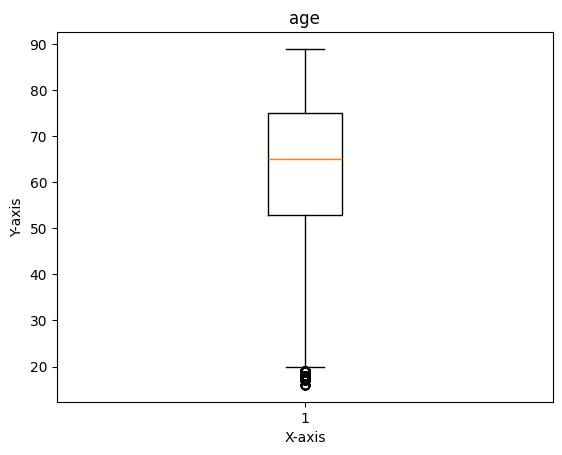

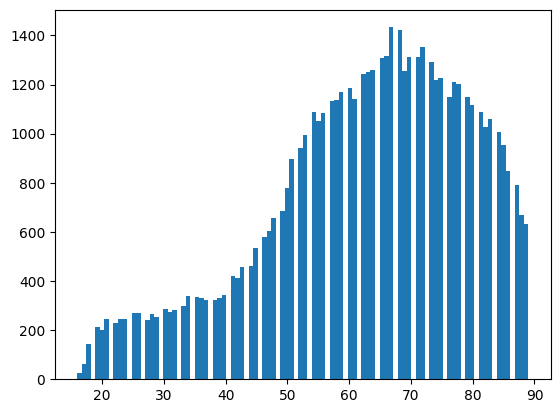

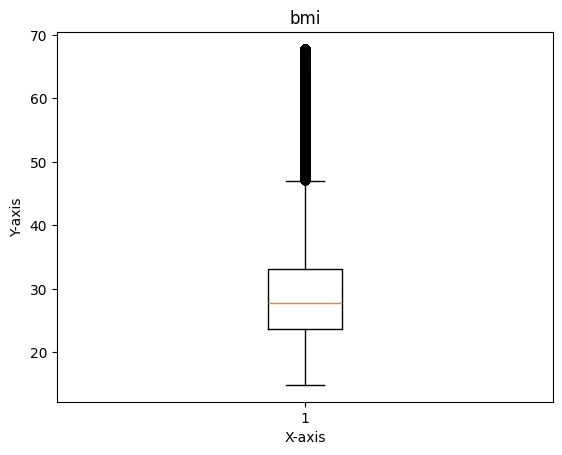

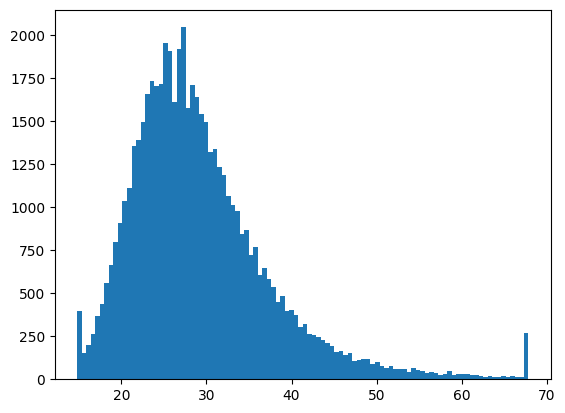

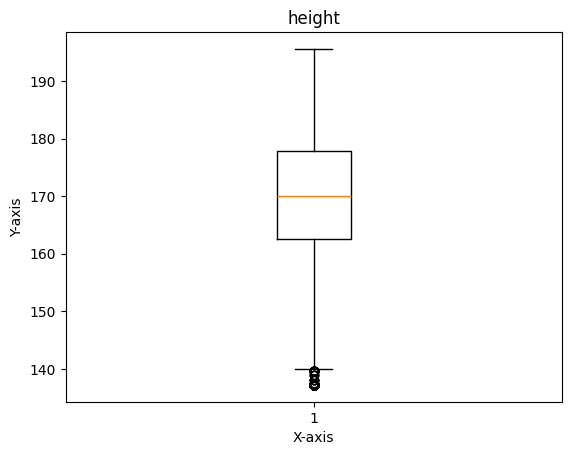

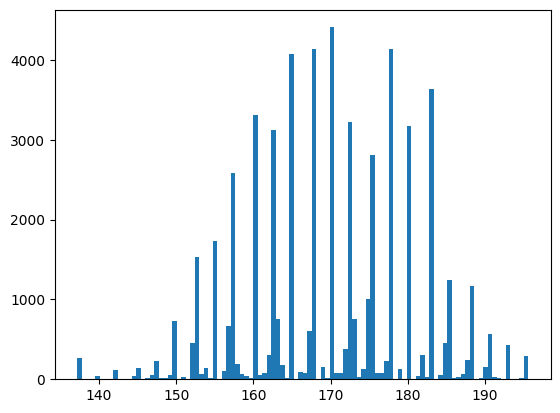

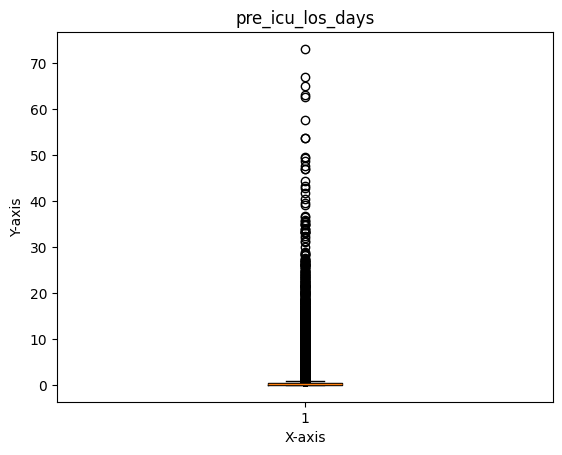

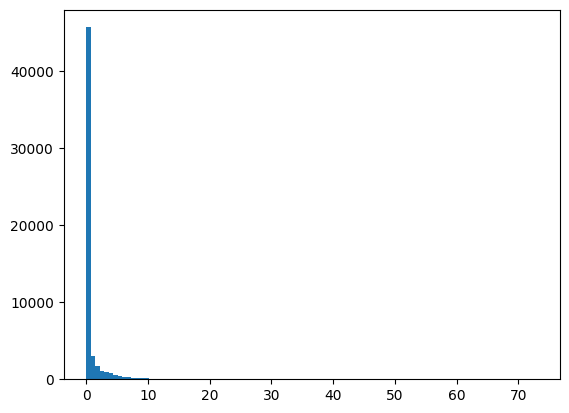

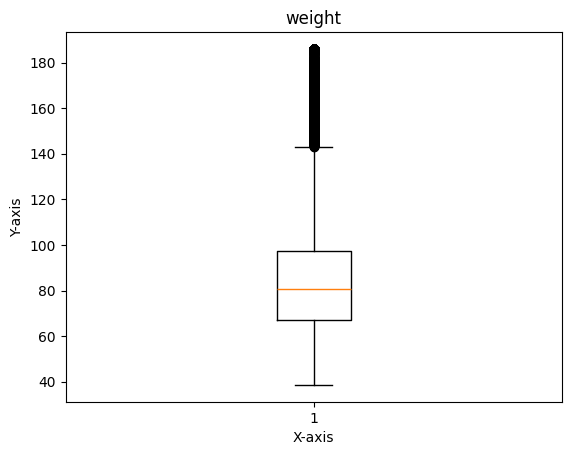

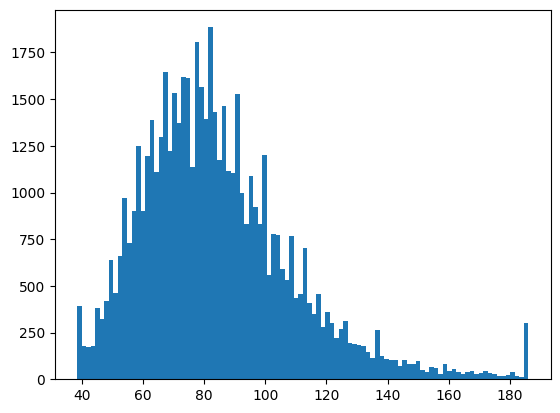

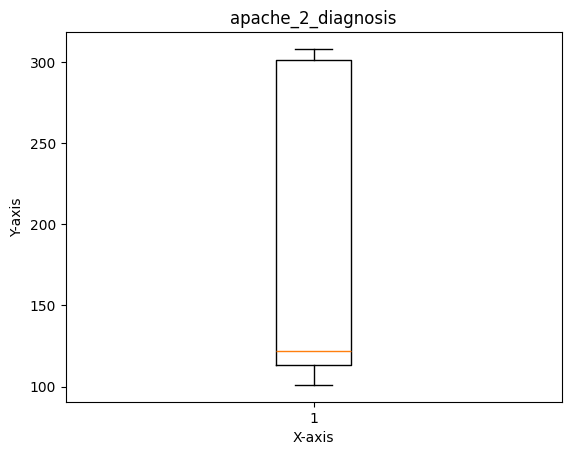

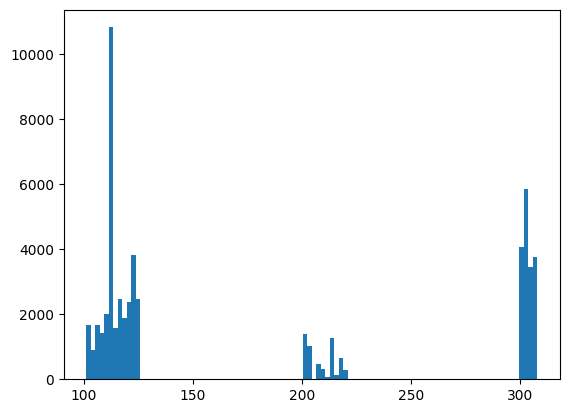

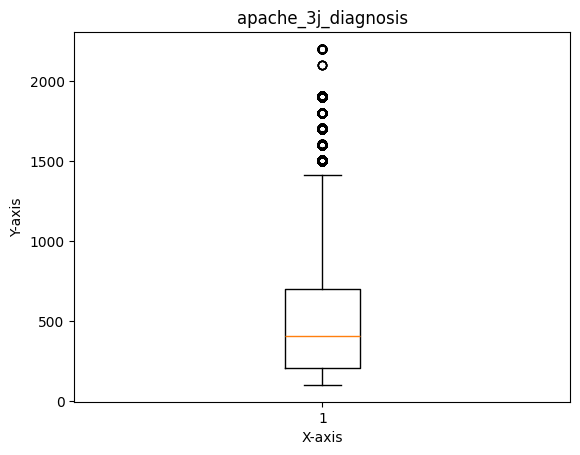

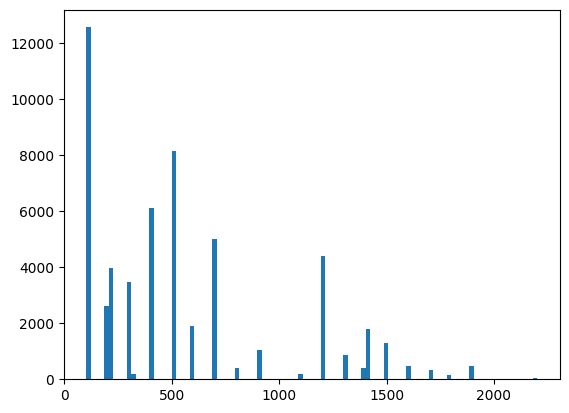

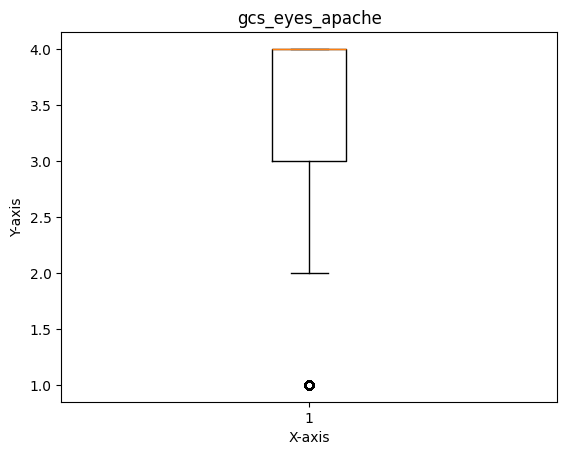

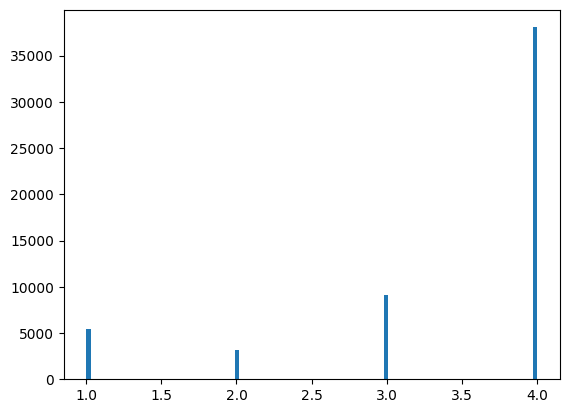

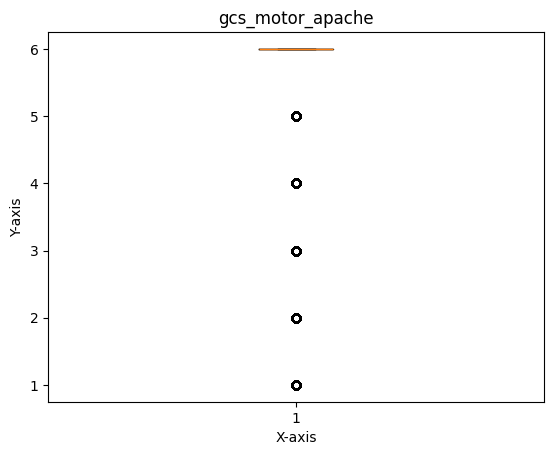

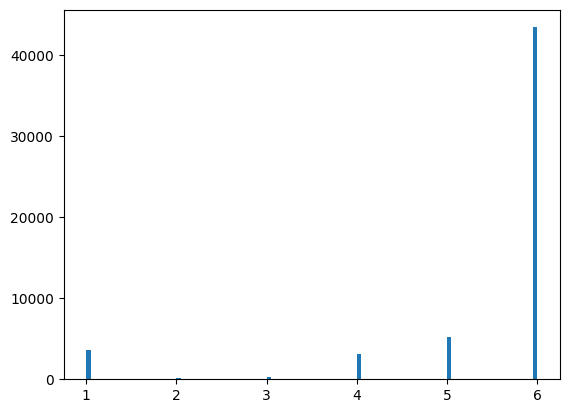

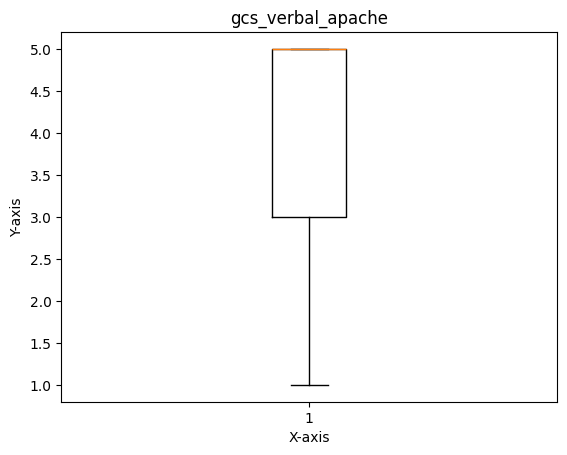

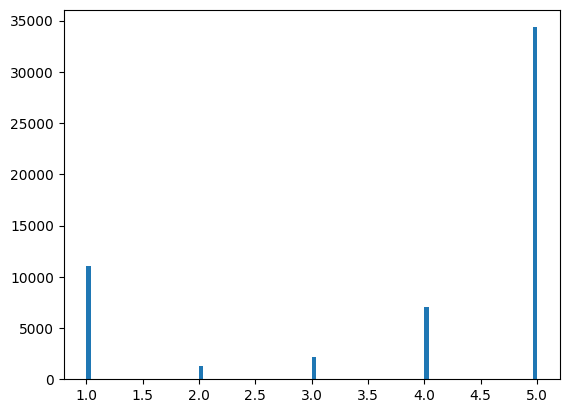

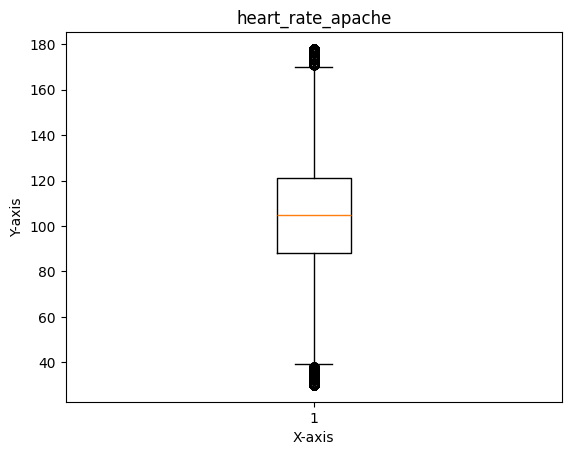

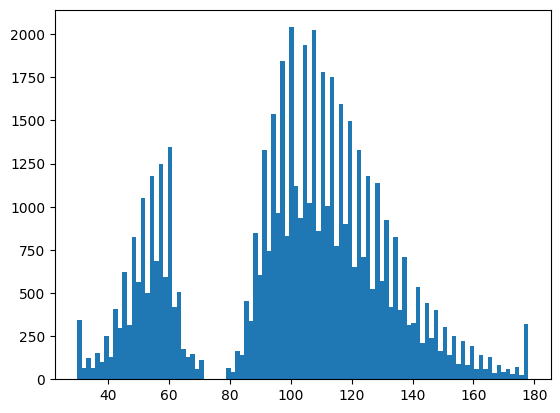

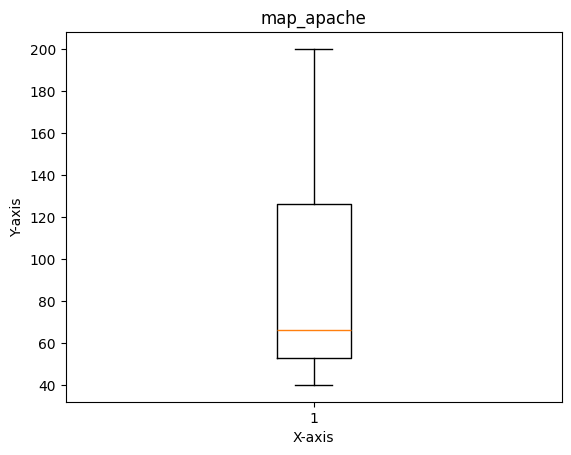

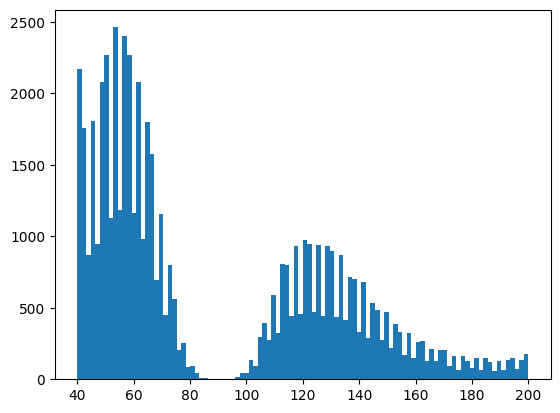

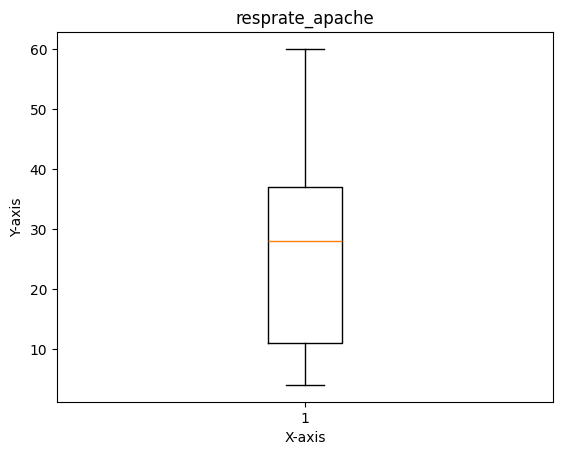

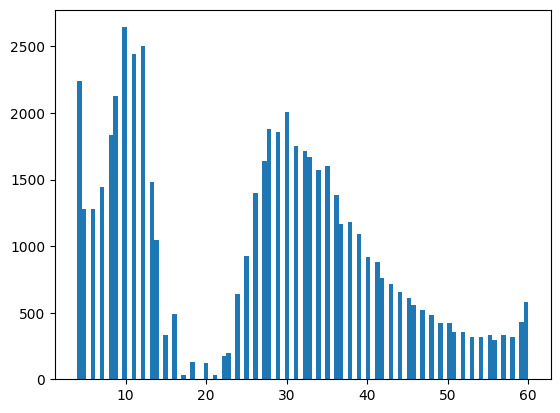

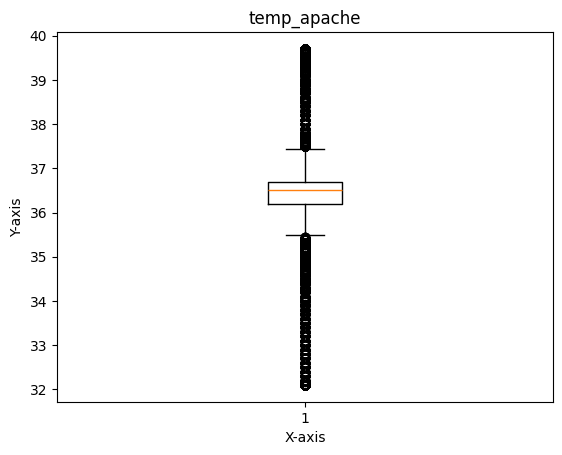

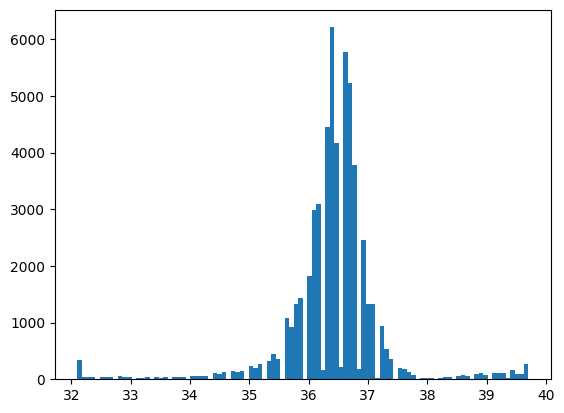

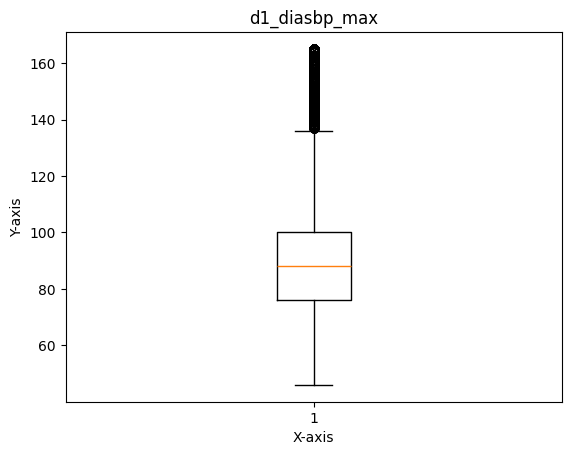

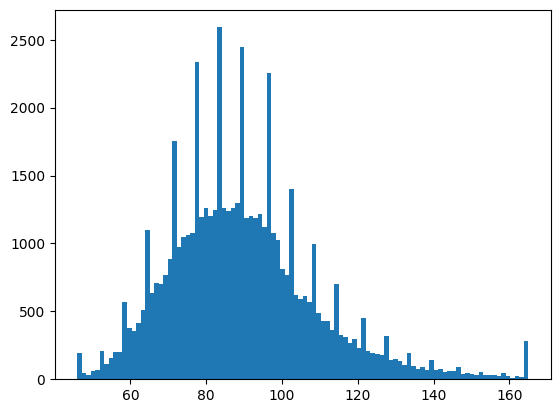

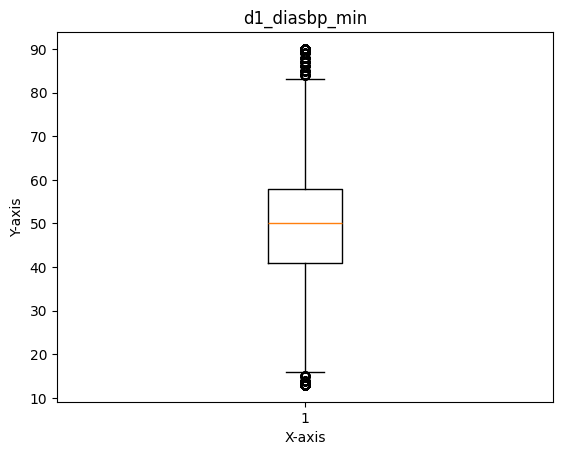

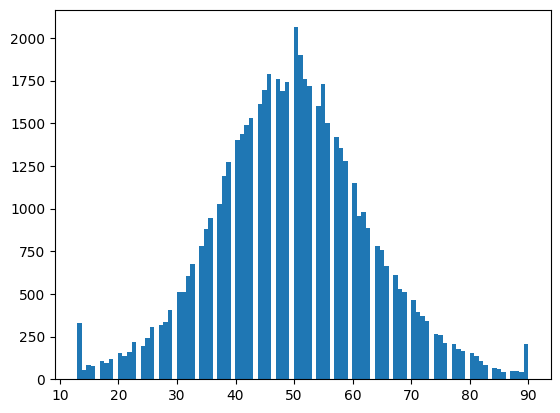

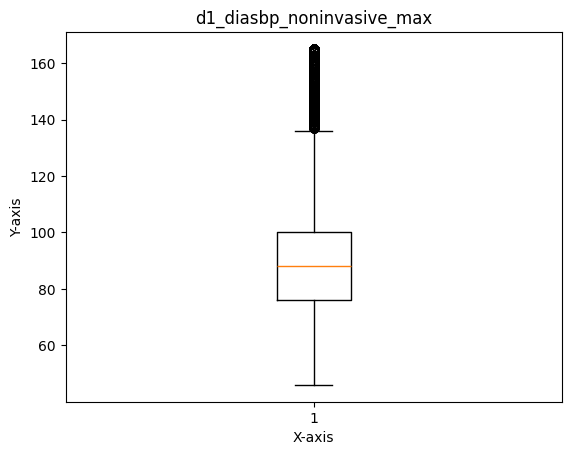

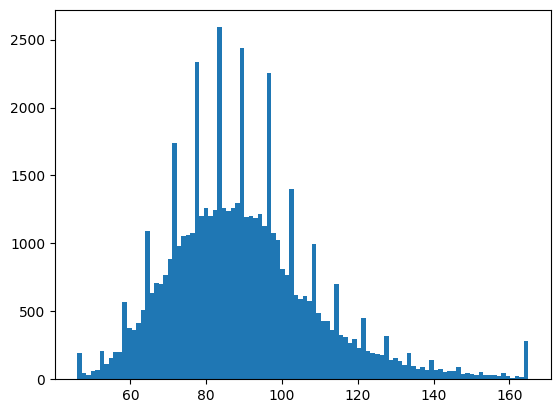

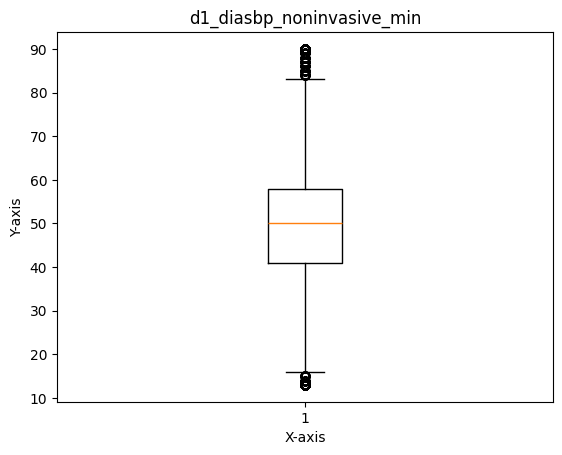

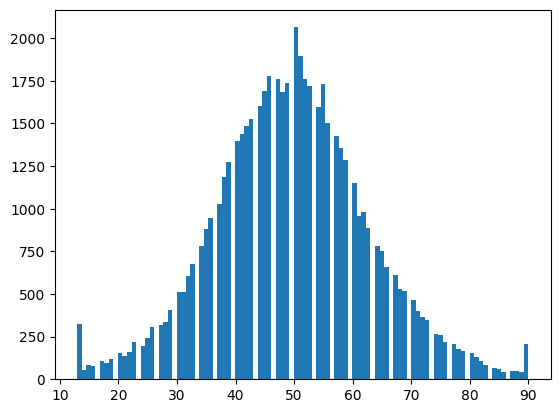

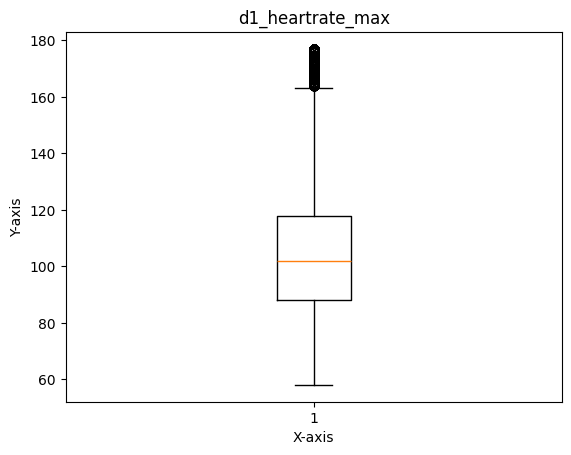

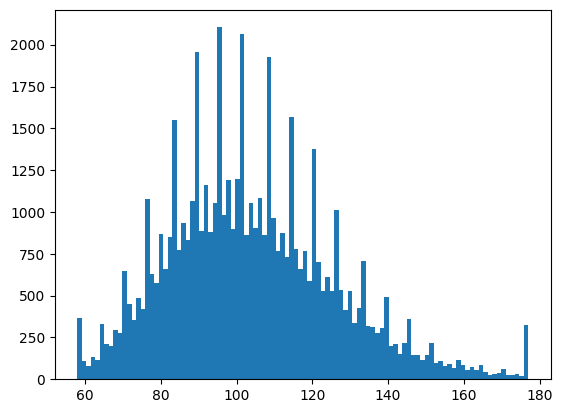

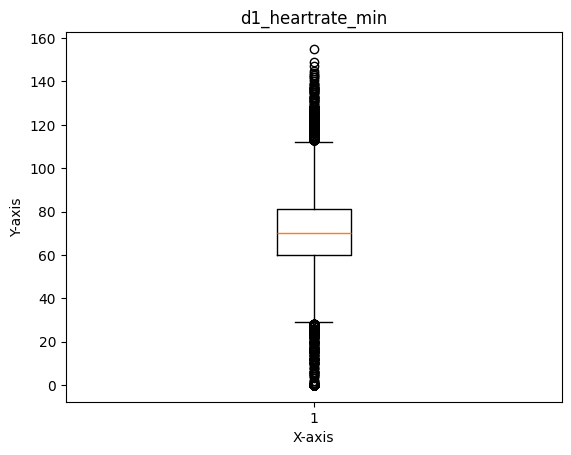

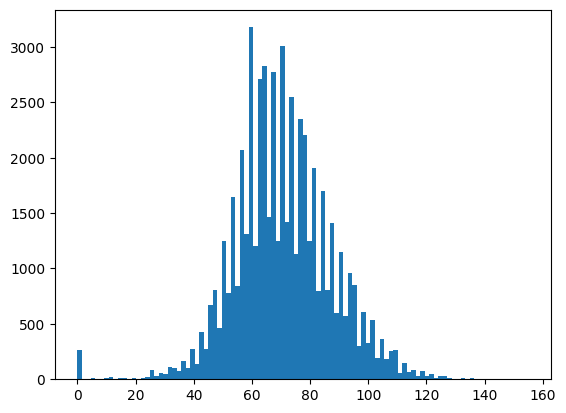

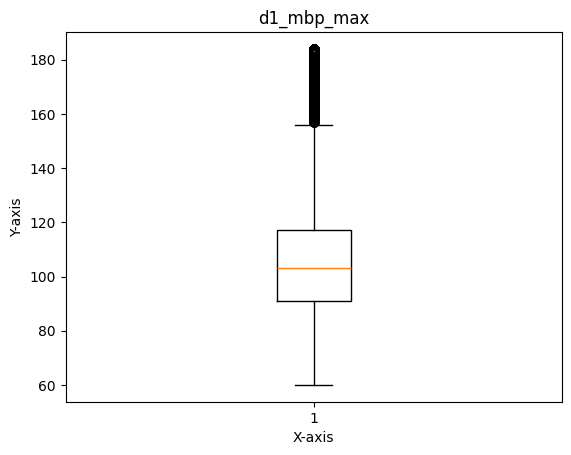

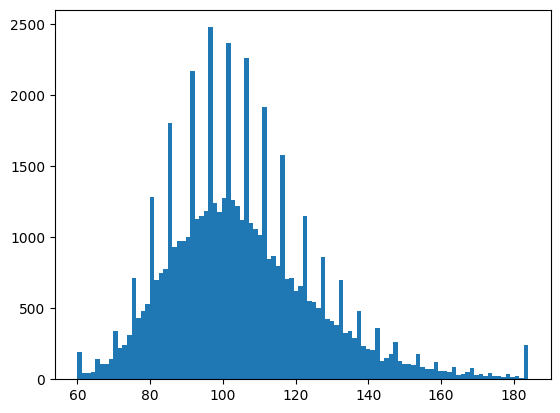

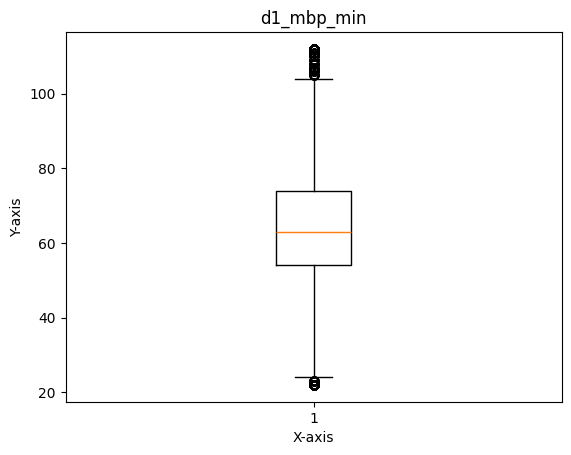

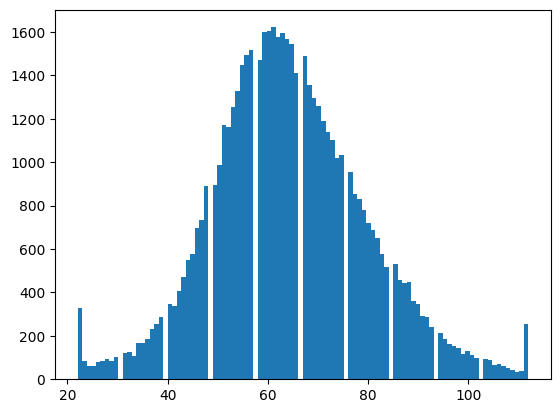

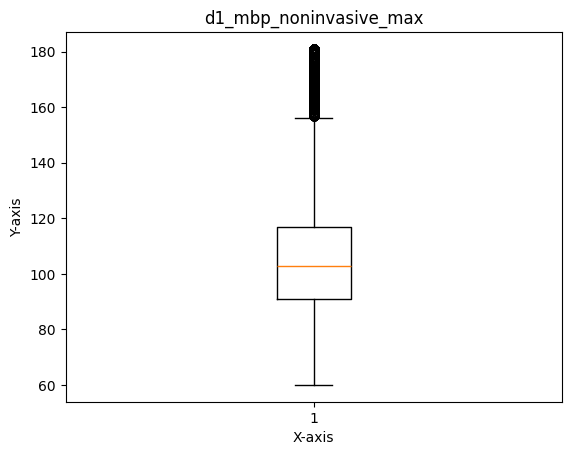

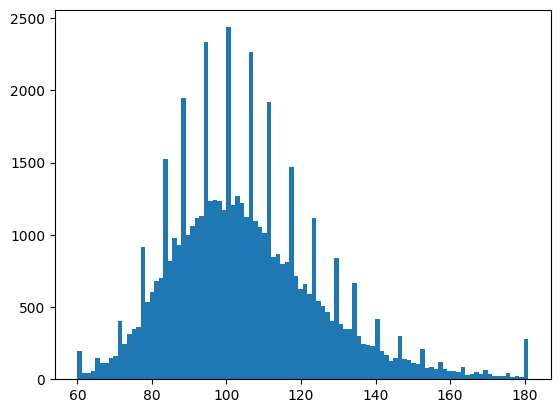

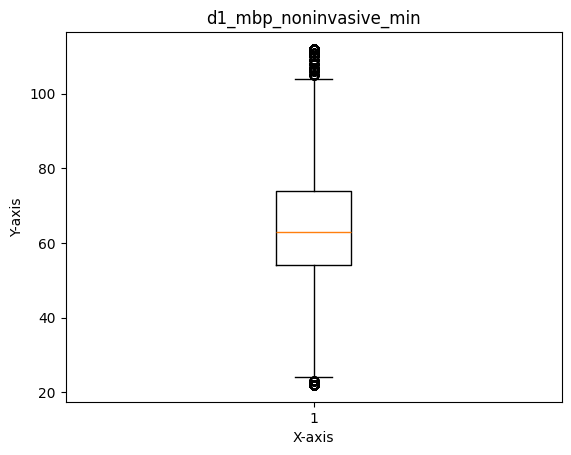

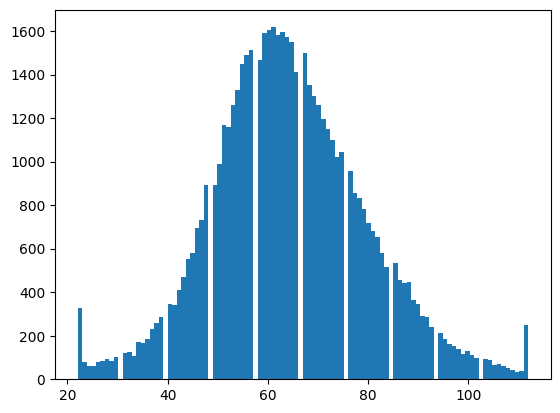

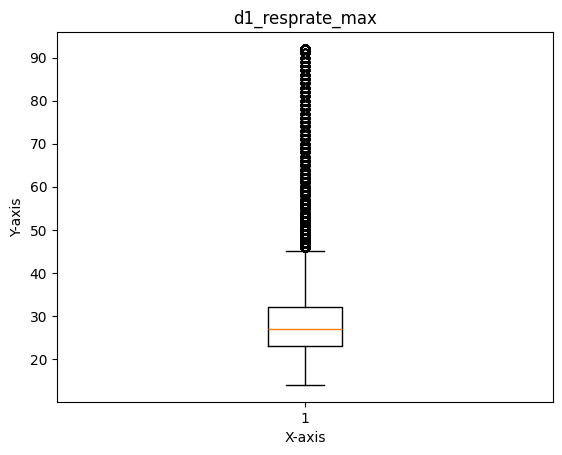

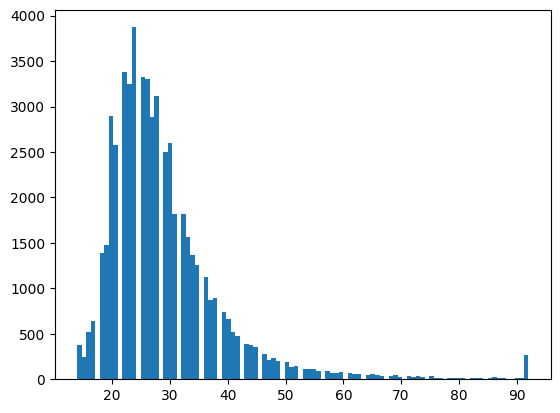

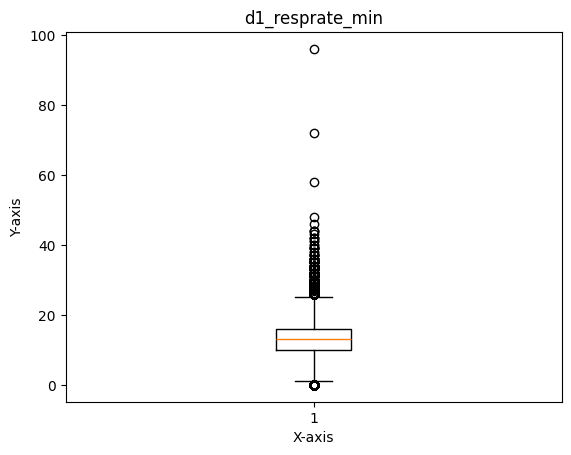

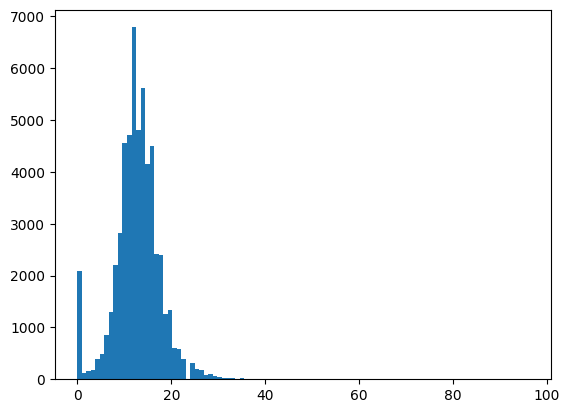

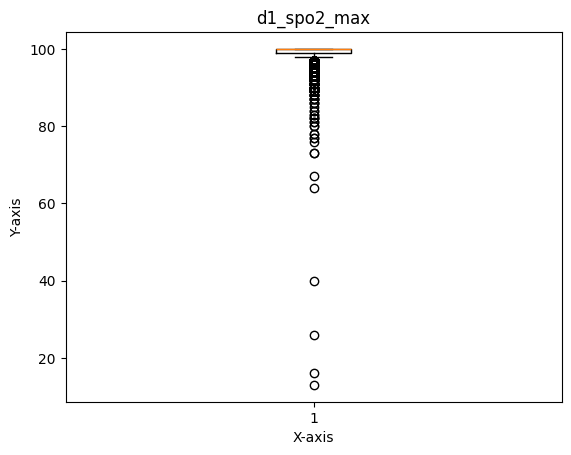

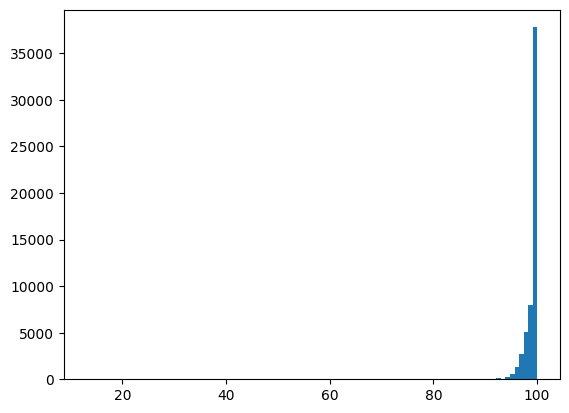

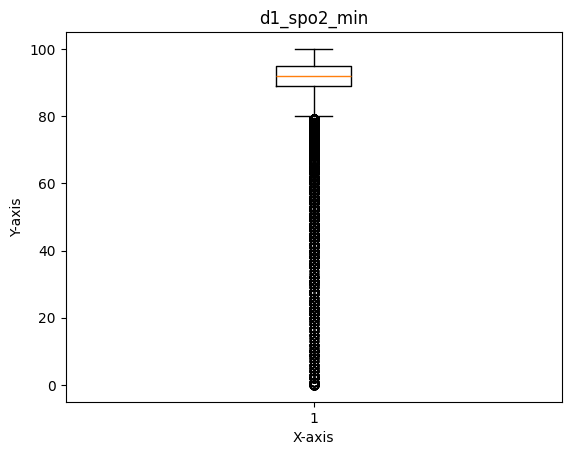

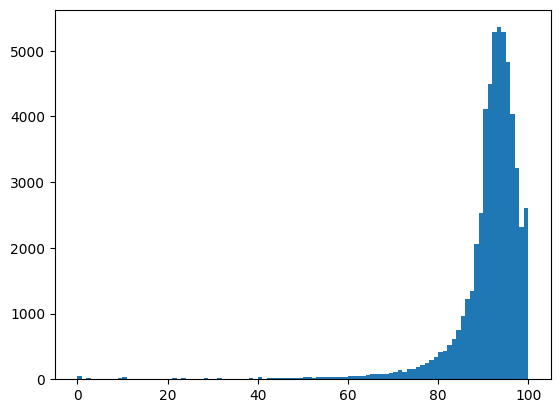

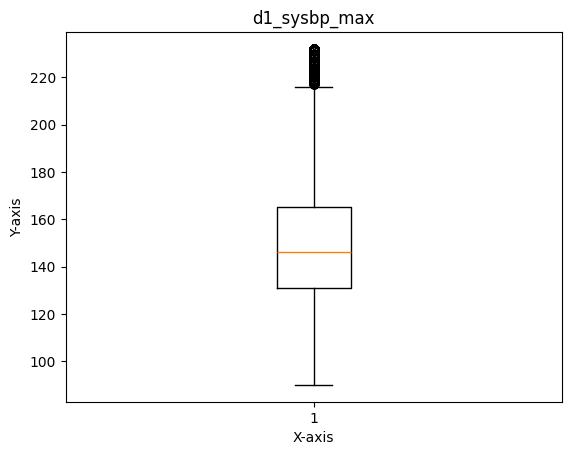

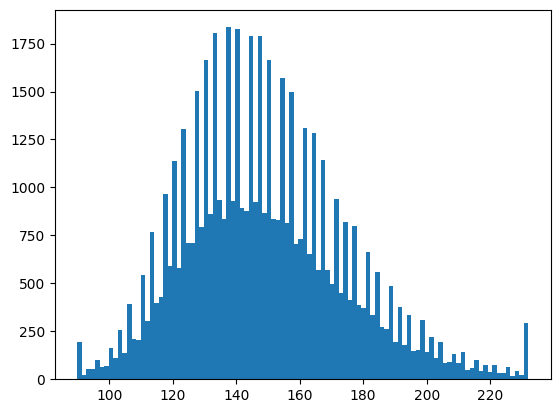

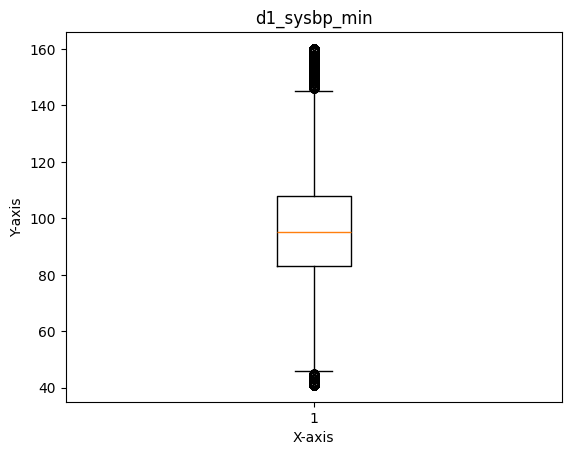

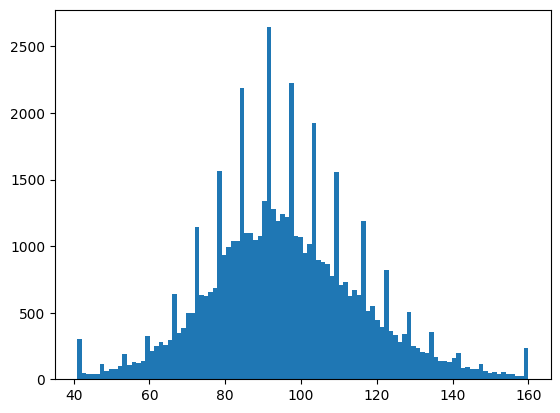

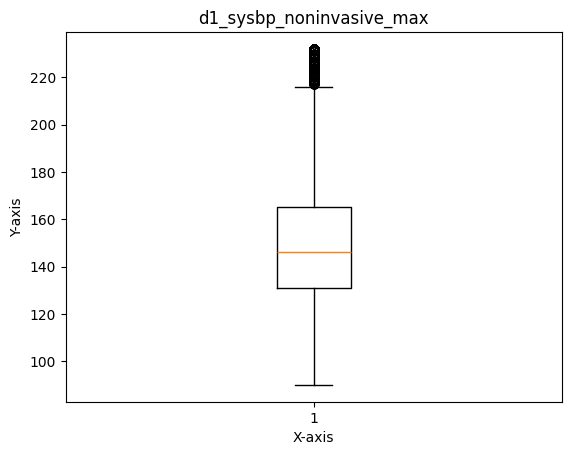

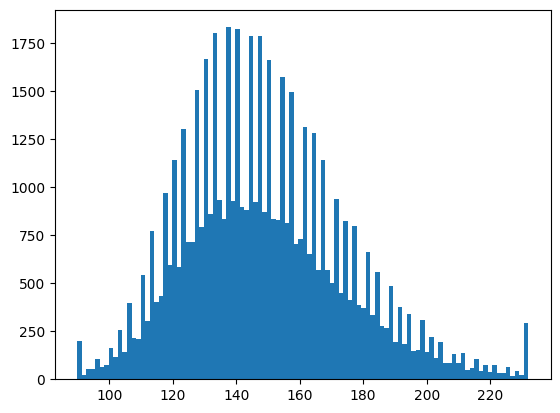

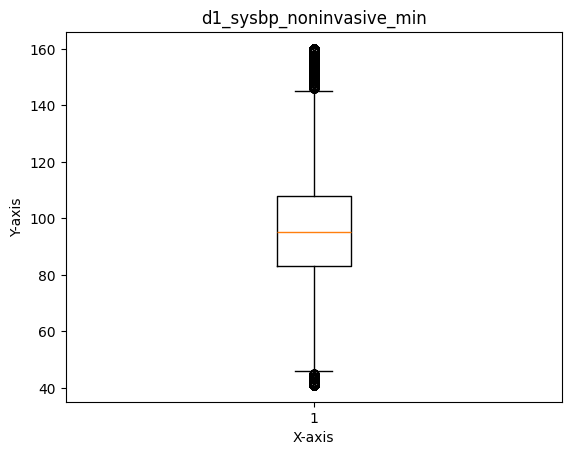

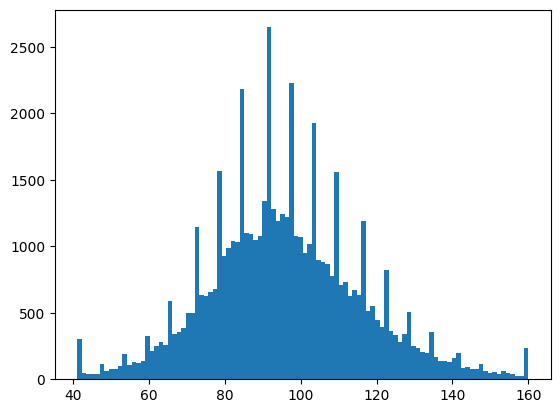

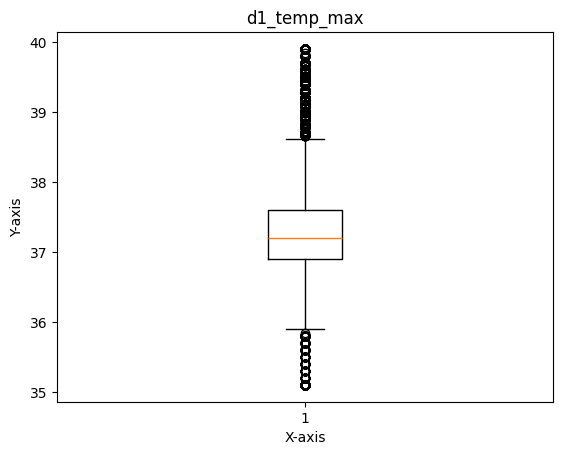

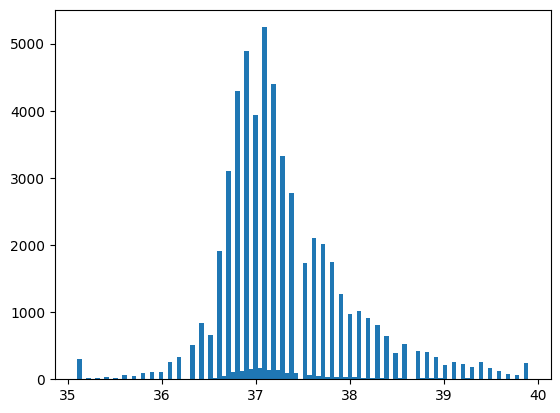

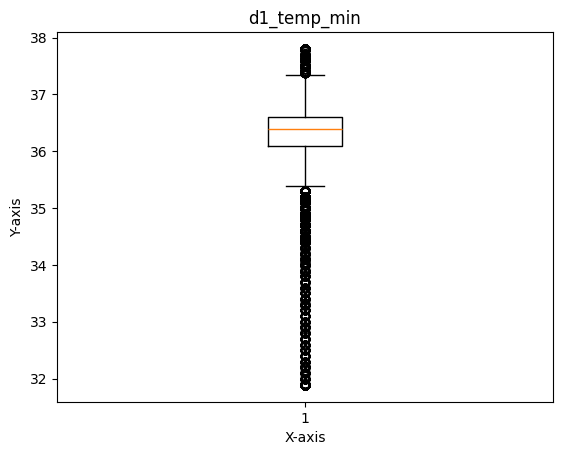

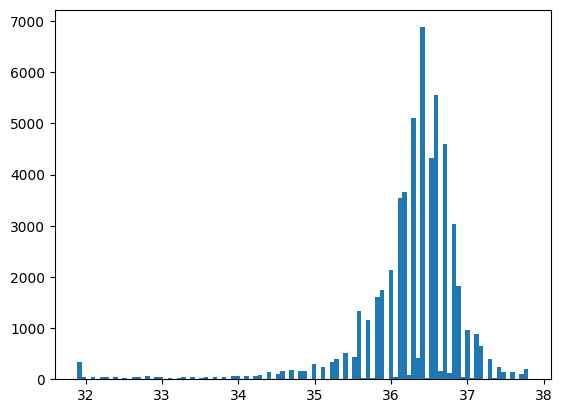

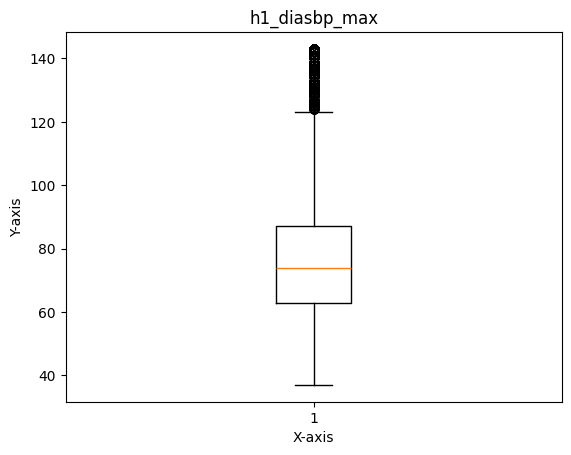

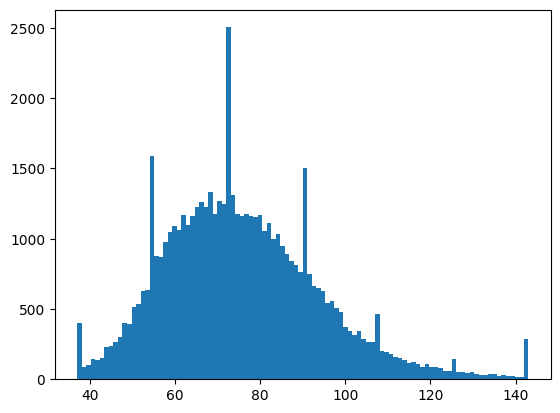

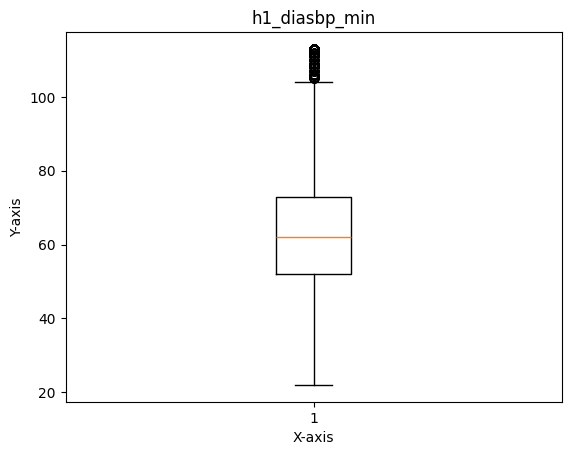

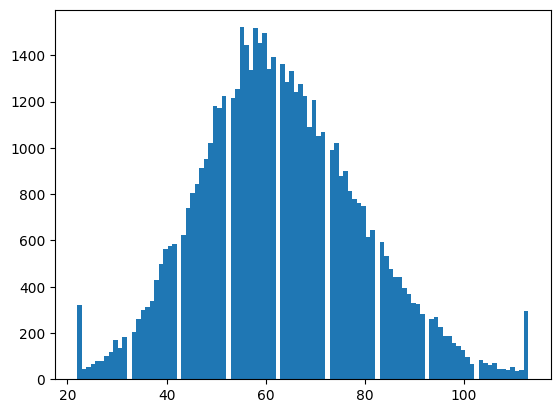

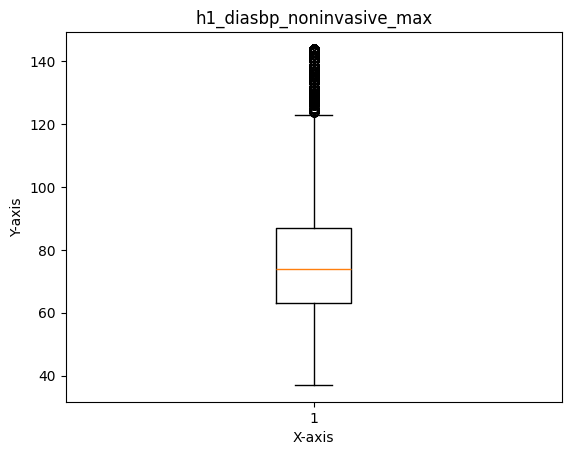

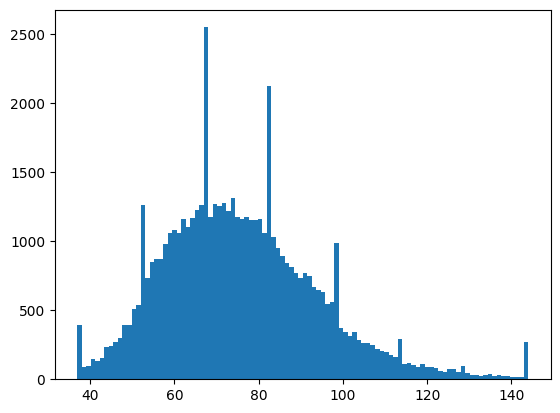

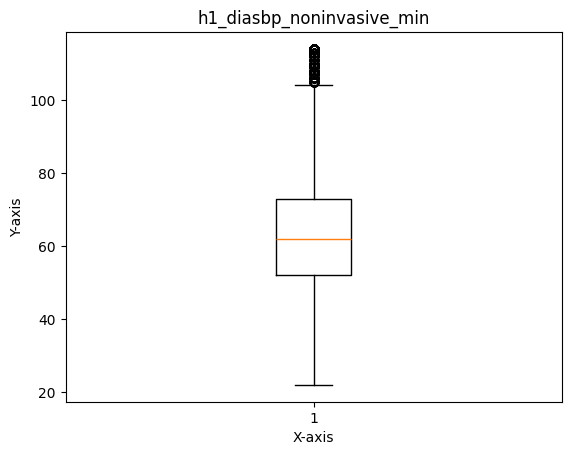

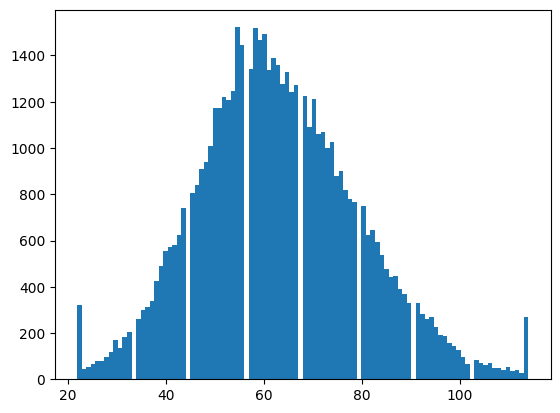

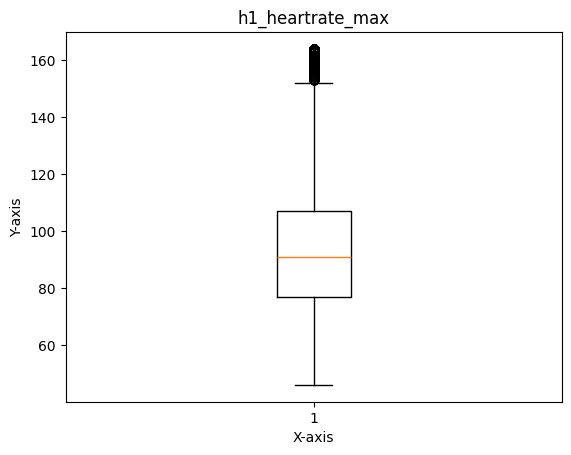

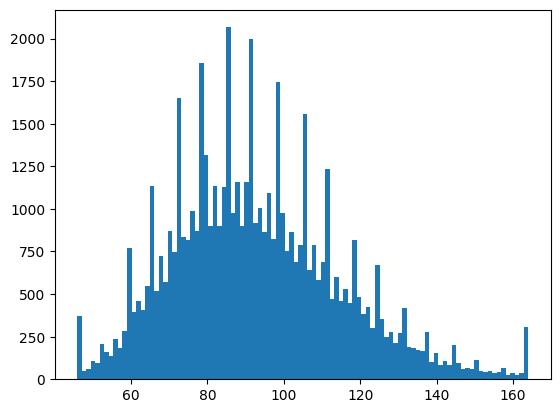

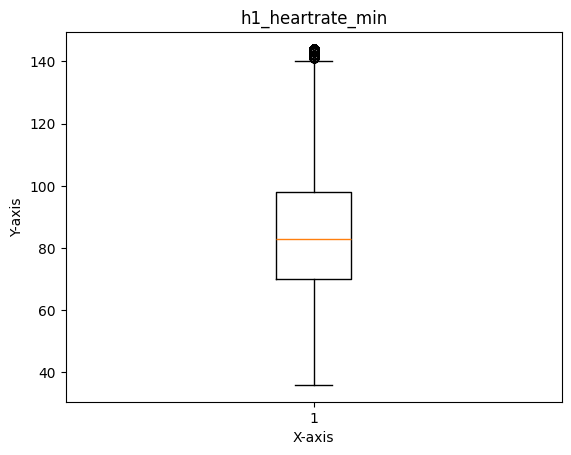

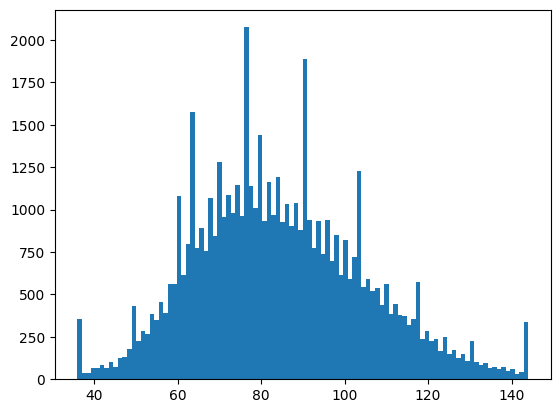

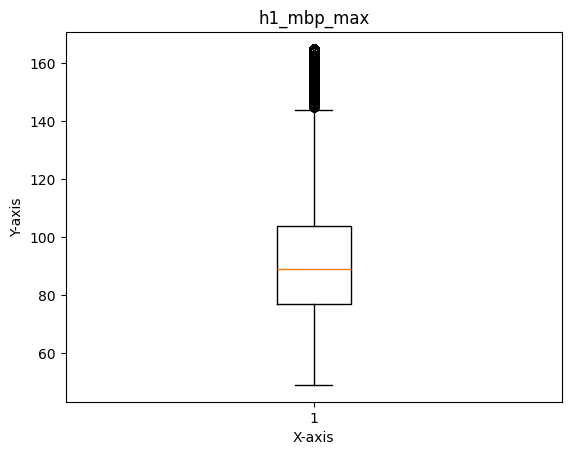

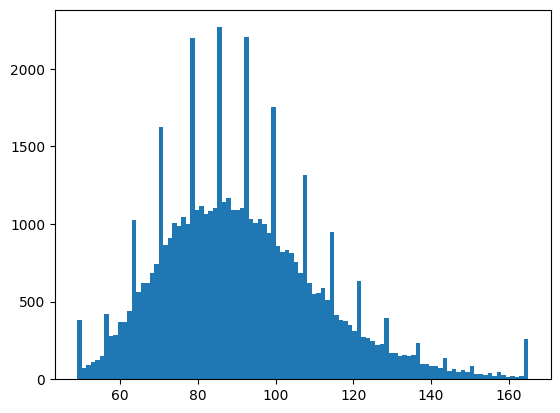

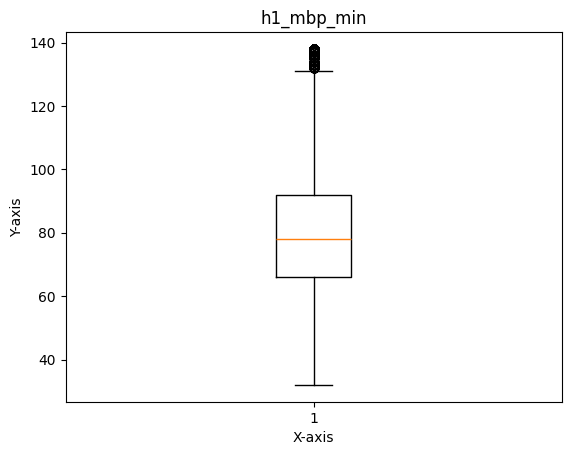

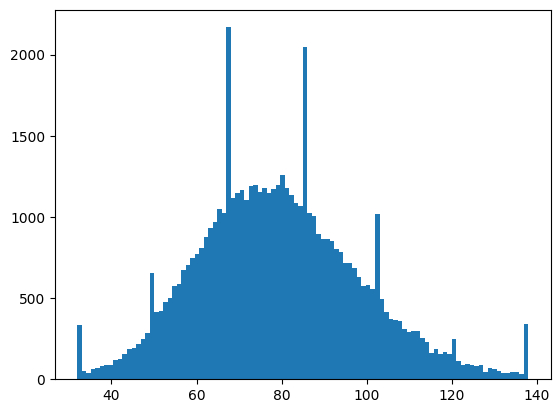

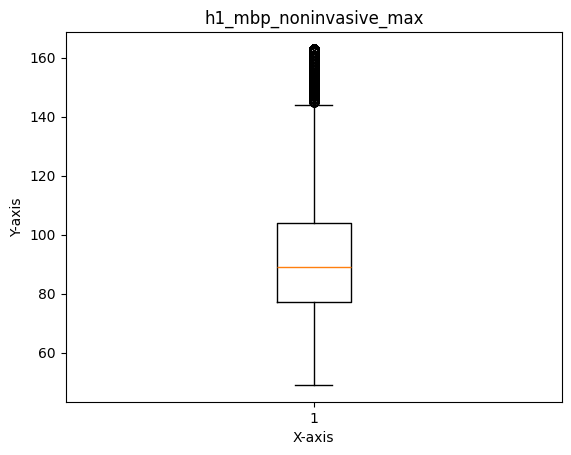

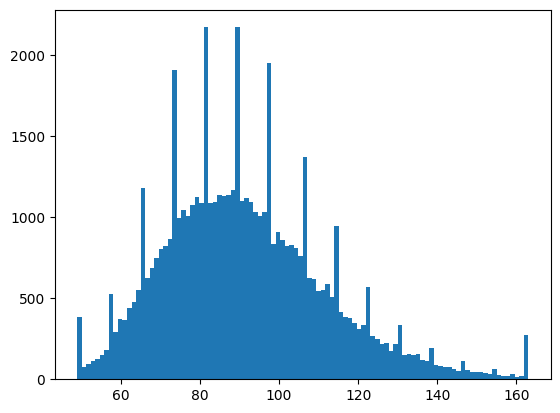

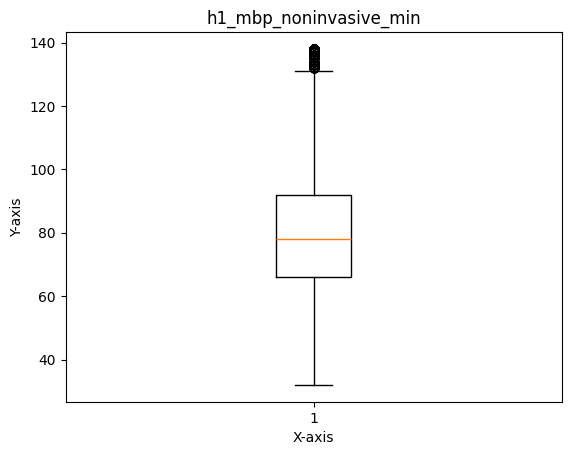

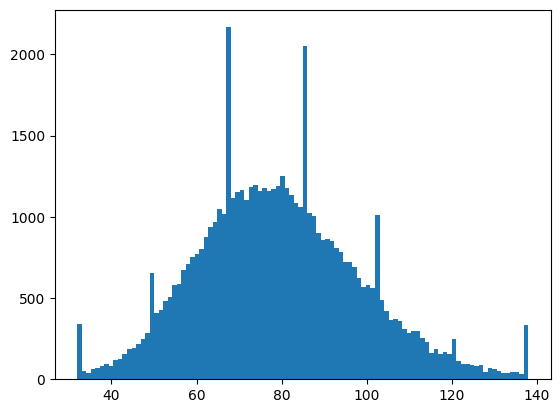

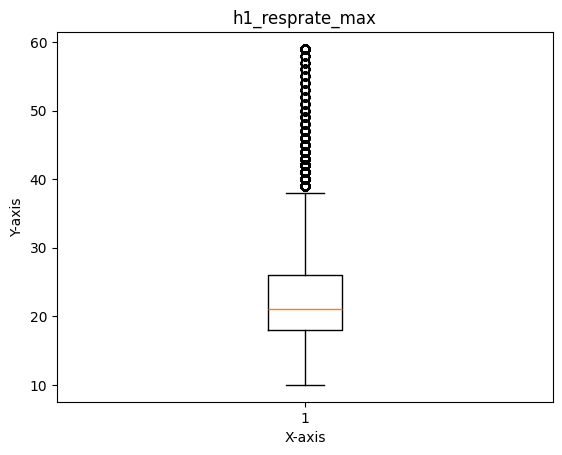

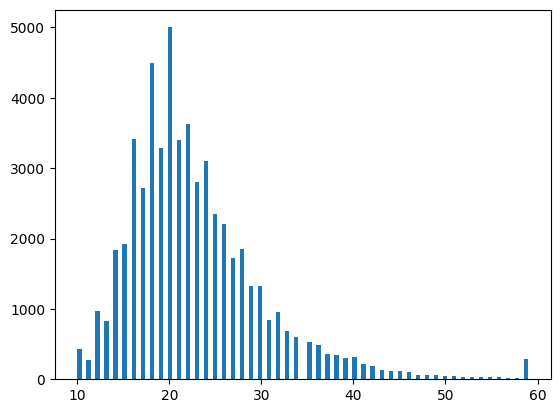

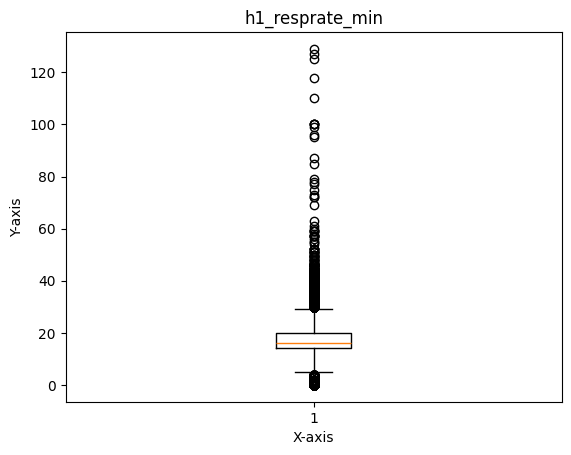

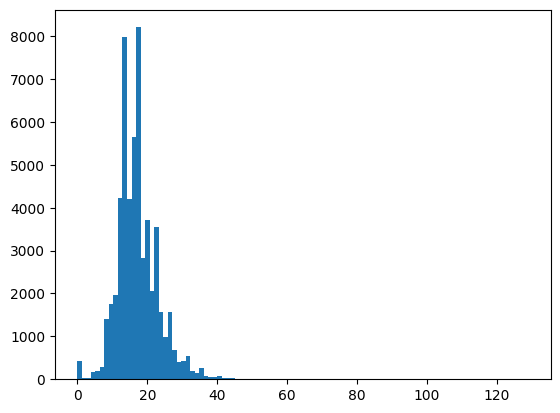

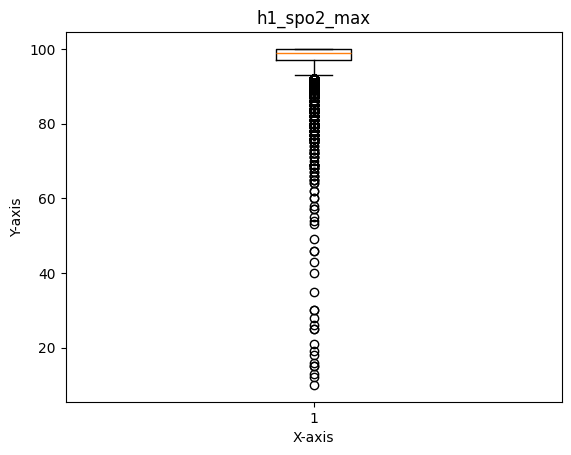

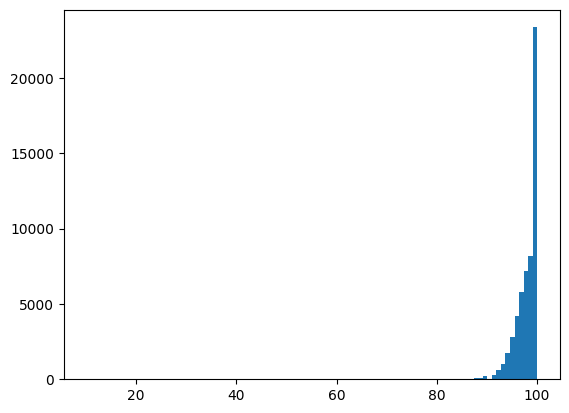

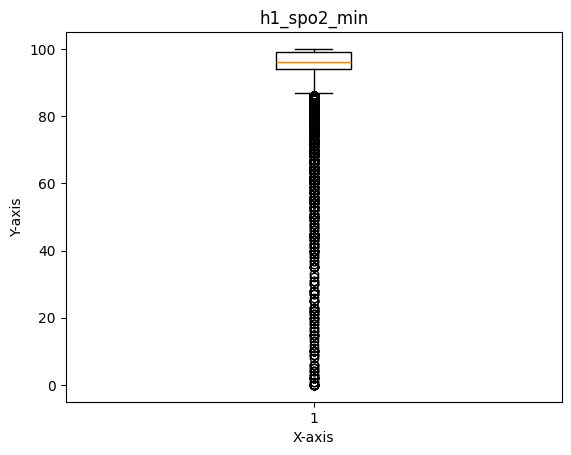

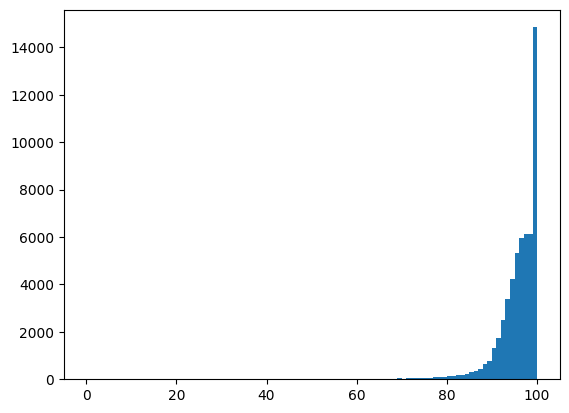

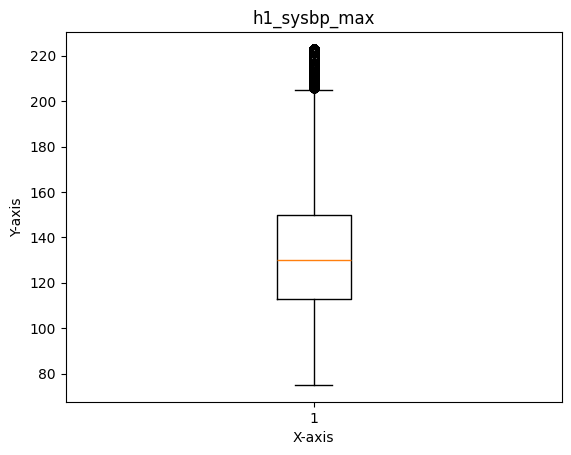

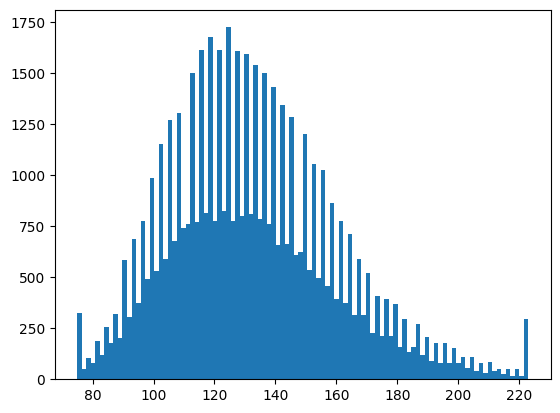

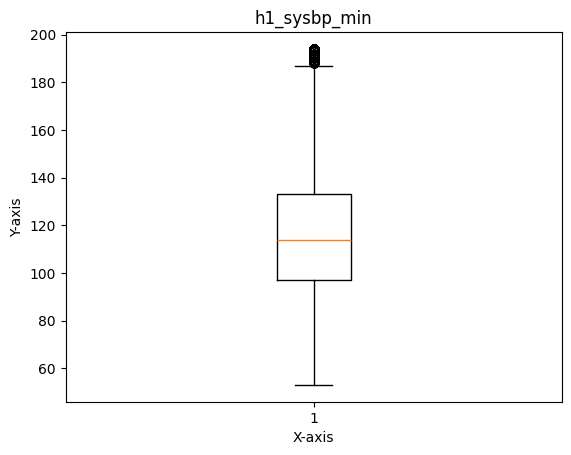

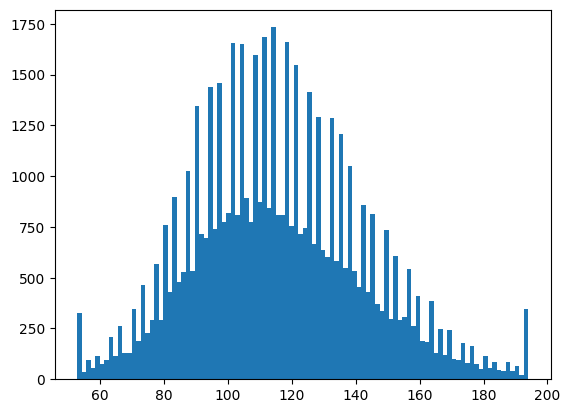

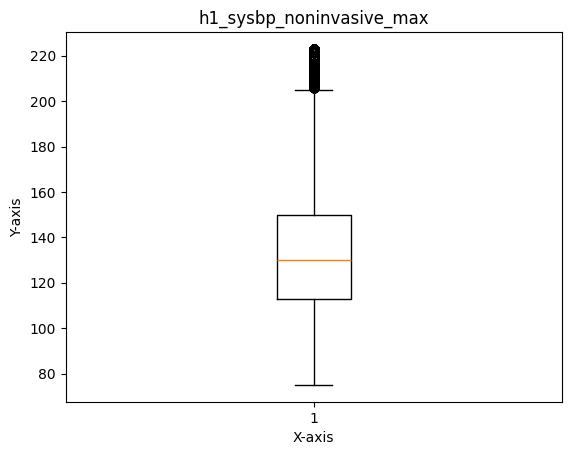

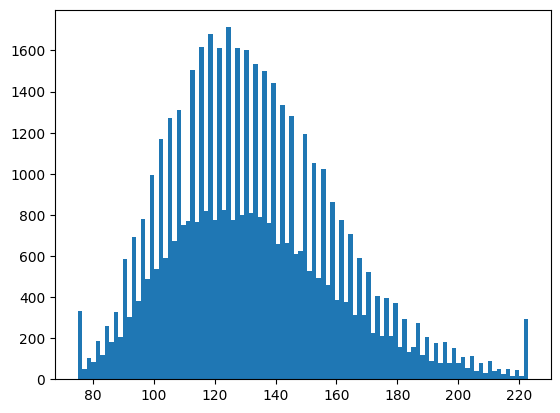

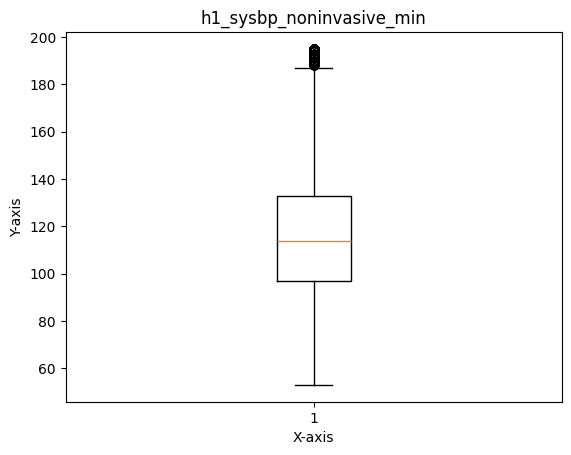

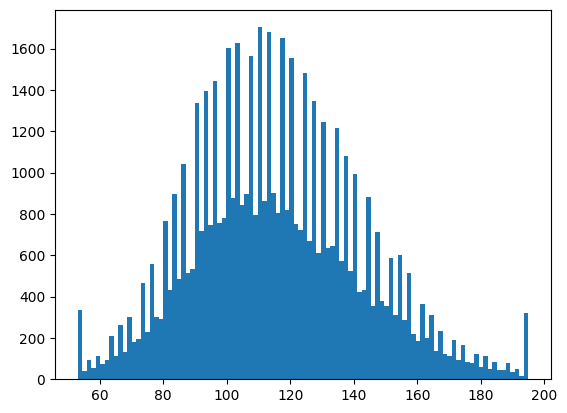

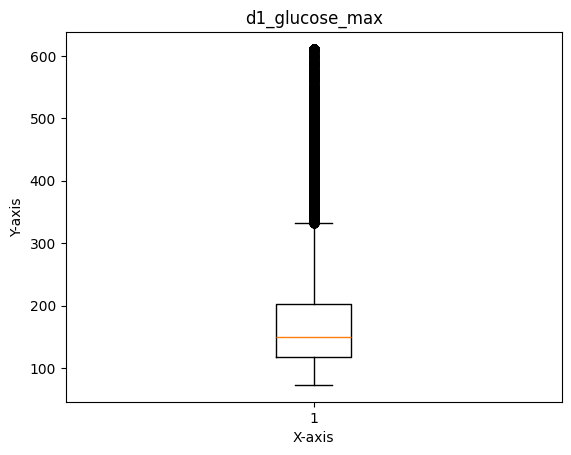

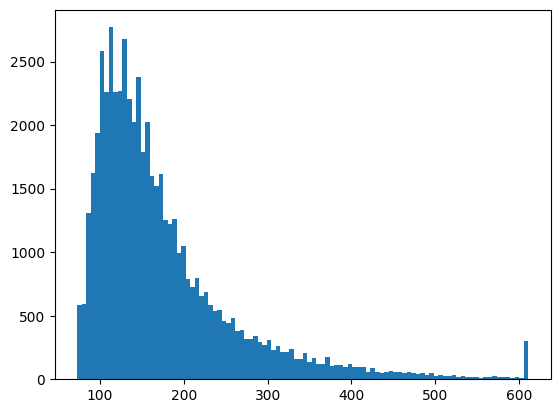

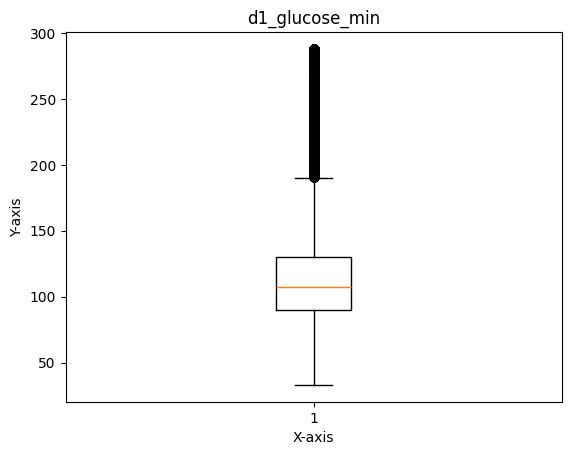

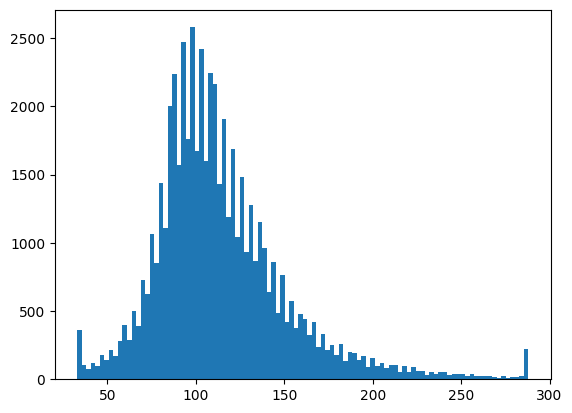

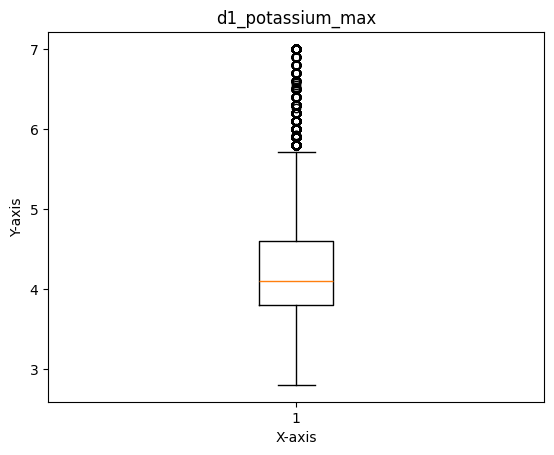

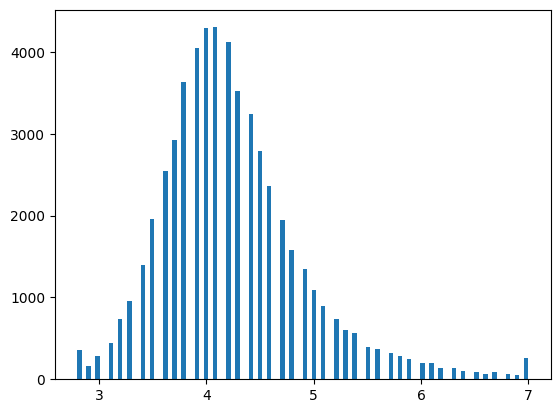

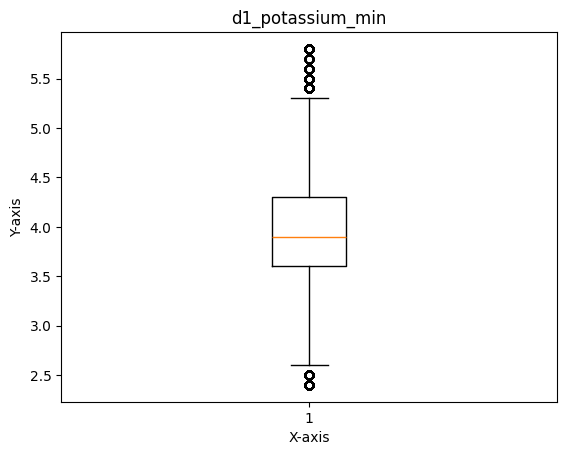

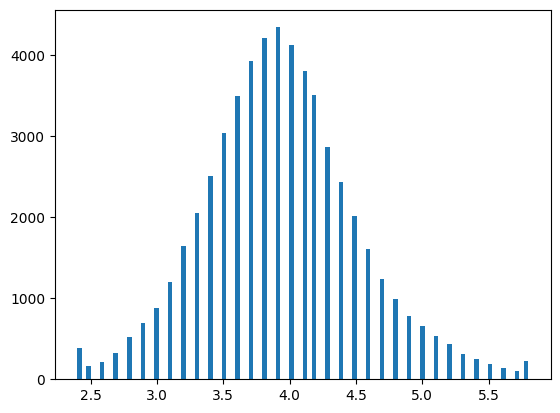

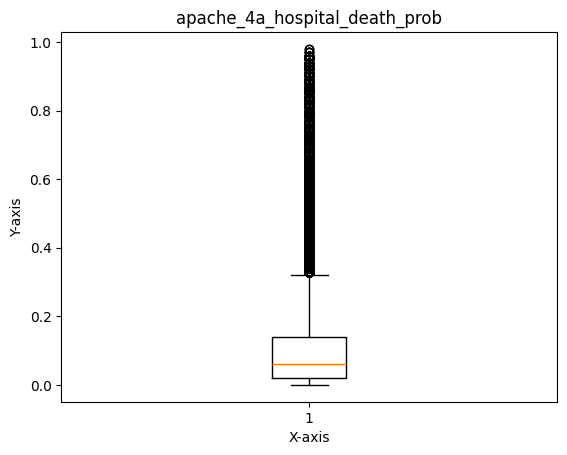

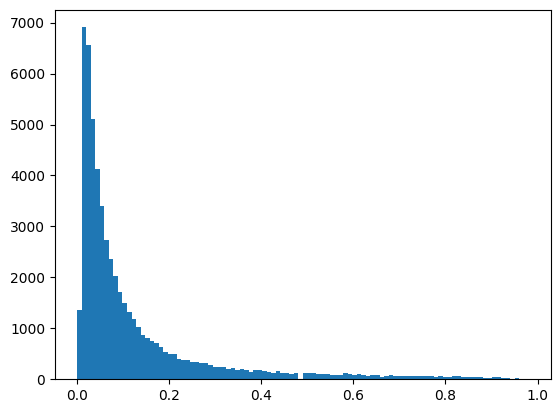

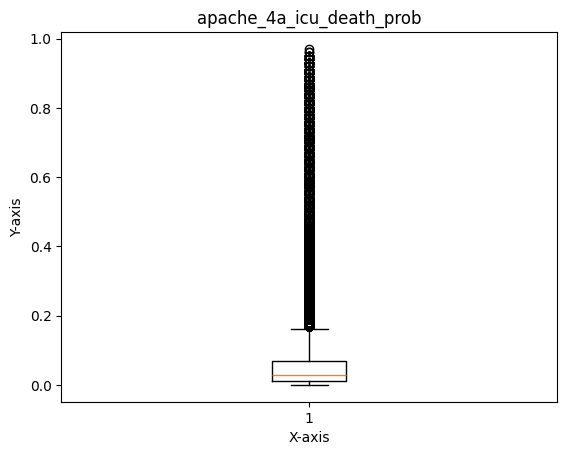

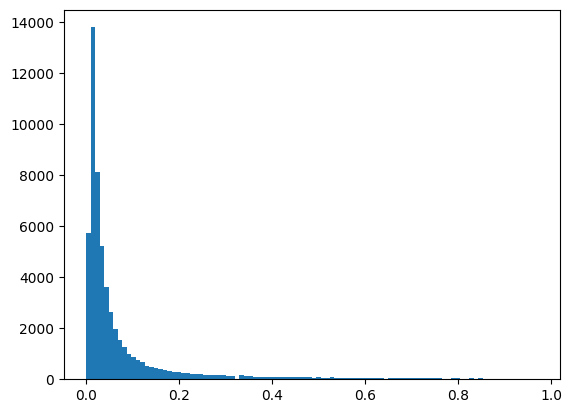

In [6]:
for col_name, dtypes in dataset_converted.dtypes.items():
    if dtypes != 'object' and len(dataset_converted[col_name].unique()) > 2:
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.title(col_name)
        plt.boxplot(dataset_converted[col_name])
        plt.show()
        plt.hist(dataset_converted[col_name], bins=100)
        plt.show()


In [7]:
num_columns = len(dataset_converted.columns)
print("Number of columns:", num_columns)

Number of columns: 111


In [8]:
# bmi_hospital_death_count = dataset_converted[['bmi', 'hospital_death', 'patient_id']].groupby(['bmi', 'hospital_death']).count()
# print(bmi_hospital_death_count)

# min_height = dataset_converted['height'].min()
# print(min_height)

# bmi_hospital_death_count = dataset_converted[['weight', 'hospital_death', 'patient_id']].groupby(['weight', 'hospital_death']).count()
# print(bmi_hospital_death_count)

# apache_4a_hospital_death_prob_min = dataset_converted['apache_4a_hospital_death_prob'].max()
# print(apache_4a_hospital_death_prob_min)

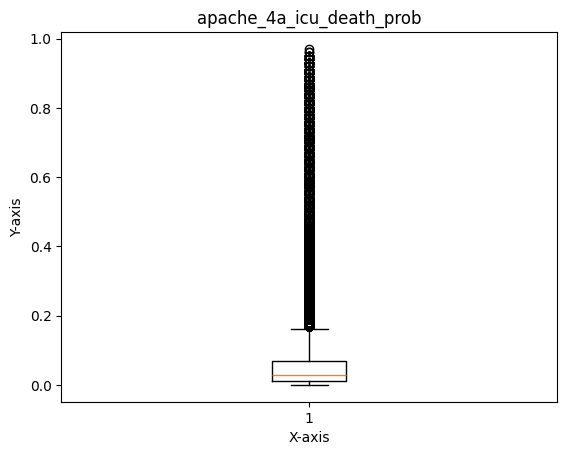

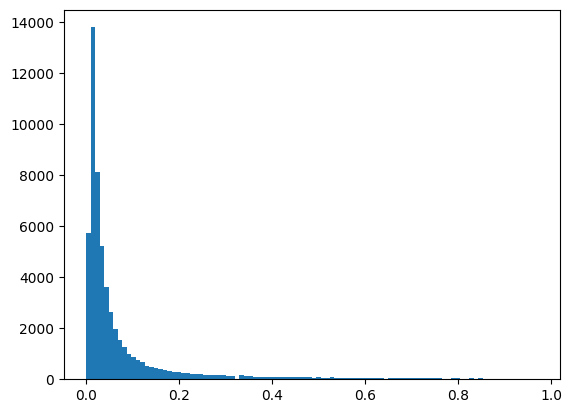

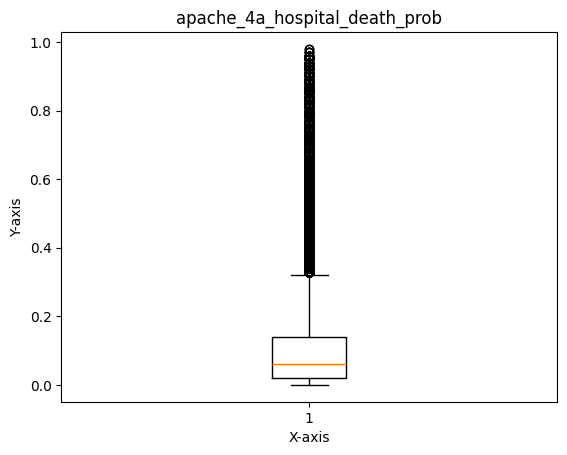

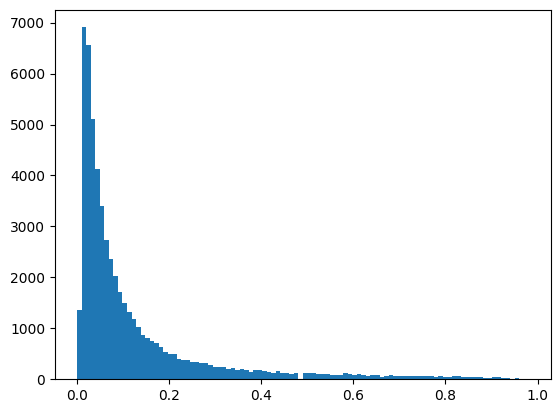

In [9]:
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title('apache_4a_icu_death_prob')
plt.boxplot(dataset_converted['apache_4a_icu_death_prob'])
plt.show()
plt.hist(dataset_converted['apache_4a_icu_death_prob'], bins=100)
plt.show()

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title('apache_4a_hospital_death_prob')
plt.boxplot(dataset_converted['apache_4a_hospital_death_prob'])
plt.show()
plt.hist(dataset_converted['apache_4a_hospital_death_prob'], bins=100)
plt.show()



In [10]:
dataset_without_outliers_dataframe = spark.createDataFrame(dataset_converted)

# checking if duplicates exist
# count_before = dataset_without_outliers.count()
# df_no_duplicates = dataset_without_outliers.dropDuplicates().count()
# print(count_before, df_no_duplicates)

# for column in dataset_without_outliers_dataframe.columns:
#     if dataset_without_outliers_dataframe.filter(dataset_without_outliers_dataframe[column] == float('inf')).count() > 0:
#         print(f"There are infinity values in column '{column}'")
#     else:
#         print(f"No infinity values in column '{column}'")

In [11]:
'''
general info:
1) Unit vector normalization: Also known as vector normalization, this technique scales each data point so that the norm (magnitude) of the vector 
representing the data point is 1. It's often used in machine learning algorithms that calculate distances between data points, 
such as K-nearest neighbors (KNN) or Support Vector Machines (SVM).

2) Normalization is useful when there are no outliers as it cannot cope up with them

3) Usually, we would scale age and not incomes because only a few people have high incomes but the age is close to uniform.
'''

"\ngeneral info:\n1) Unit vector normalization: Also known as vector normalization, this technique scales each data point so that the norm (magnitude) of the vector \nrepresenting the data point is 1. It's often used in machine learning algorithms that calculate distances between data points, \nsuch as K-nearest neighbors (KNN) or Support Vector Machines (SVM).\n\n2) Normalization is useful when there are no outliers as it cannot cope up with them\n\n3) Usually, we would scale age and not incomes because only a few people have high incomes but the age is close to uniform.\n"

## Feature Engineering With Map Reduce

In [12]:
import threading 

def my_map(func, iterable):
    mapped_iterable = {}
    threads = []
    for idx, item in enumerate(iterable):
        thread = threading.Thread(target=lambda: mapped_iterable.update({idx: func(item)}))
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()
    return mapped_iterable

def my_reduce(func, iterable):
    result = {}
    for item in iterable.values():
        result = func(result, item)
    return result

def map_func(chunk):
    numerical_col = []
    categorical_col = []

    target = 'hospital_death'
    for col in chunk.columns:
        if col == target:
            continue
        elif chunk[col].dtype == int or chunk[col].dtype == float:
            numerical_col.append(col)
        else:
            categorical_col.append(col)

    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_col),
            ('cat', categorical_transformer, categorical_col)
        ], remainder='passthrough'
    )

    x = chunk.drop('hospital_death', axis=1)
    y = chunk['hospital_death']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    classifier = LogisticRegression(random_state=42, max_iter=100000)
    MyPipeline= Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    MyPipeline.fit(x_train, y_train)

    y_pred = MyPipeline.predict(x_test)

    return {'data': (y_test, y_pred)}  

def reduce_func(results):
    y_true = []
    y_pred = []

    for key, value in results.items():
        y, y_pred_chunk = value['data'] 
        y_true.extend(y)
        y_pred.extend(y_pred_chunk)

    return {'results': (y_true, y_pred)} 


data_pd = dataset_without_outliers_dataframe.toPandas()
num_chunks = 4


chunk_size = len(data_pd) // num_chunks
remainder = len(data_pd) % num_chunks  
start_index = 0
chunks = []
for i in range(num_chunks):
        end_index = start_index + chunk_size
        if i < remainder: 
            end_index += 1
        chunks.append(data_pd[start_index:end_index])
        start_index = end_index


mapped_results = my_map(map_func, chunks)
reduced_results = reduce_func(mapped_results)

accuracy = accuracy_score(reduced_results['results'][0], reduced_results['results'][1])
print("Accuracy:", accuracy)




Accuracy: 0.9022361359570662


### Map reduce threading

In [13]:
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# import threading


# def map_func(chunk, result_chunk):
#     numerical_col = []
#     categorical_col = []

#     target = 'hospital_death'
#     for col in chunk.columns:
#         if col == target:
#             continue
#         elif chunk[col].dtype == int or chunk[col].dtype == float:
#             numerical_col.append(col)
#         else:
#             categorical_col.append(col)

#     numeric_transformer = StandardScaler()
#     categorical_transformer = OneHotEncoder(handle_unknown='ignore')

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numeric_transformer, numerical_col),
#             ('cat', categorical_transformer, categorical_col)
#         ], remainder='passthrough'
#     )

#     classifier = LogisticRegression(random_state=42, max_iter=1000000)

#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', classifier)
#     ])

#     x = chunk.drop('hospital_death', axis=1)
#     y = chunk['hospital_death']

#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#     pipeline.fit(x_train, y_train)

#     y_pred = pipeline.predict(x_test)
#     result_chunk.extend(list(zip(y_test, y_pred)))


# def reduce_func(results):
#     y_true = []
#     y_pred = []

#     for result_chunk in results:
#         for y, y_pred_chunk in result_chunk:
#             y_true.append(y)
#             y_pred.append(y_pred_chunk)

#     return y_true, y_pred

# if __name__ == '__main__':
    
#     data_pd = dataset_without_outliers_dataframe.toPandas()
#     print("len of data_pd: ", len(data_pd))
#     num_chunks = 4 

   
#     chunk_size = len(data_pd) // num_chunks
#     remainder = len(data_pd) % num_chunks  
#     start_index = 0
#     chunks = []
#     for i in range(num_chunks):
#         end_index = start_index + chunk_size
#         if i < remainder: 
#             end_index += 1
#         chunks.append(data_pd[start_index:end_index])
#         start_index = end_index


   
#     threads = []
#     mapped_results = []
#     for chunk in chunks:
#         result_chunk = []  
#         print("len of chunks: ", len(chunk))
#         thread = threading.Thread(target=map_func, args=(chunk, result_chunk))

#         threads.append(thread)
#         thread.start()
#         mapped_results.append(result_chunk)

    
#     for thread in threads:
#         thread.join()

    
#     reduced_results = reduce_func(mapped_results)

#     accuracy = accuracy_score(reduced_results[0], reduced_results[1])
#     print("Accuracy:", accuracy)


## Map reduce mrjob 

In [14]:
    # from mrjob.job import MRJob
    # from mrjob.step import MRStep
    # from sklearn.model_selection import train_test_split
    # from sklearn.preprocessing import StandardScaler, OneHotEncoder
    # from sklearn.compose import ColumnTransformer
    # from sklearn.linear_model import LogisticRegression
    # from sklearn.metrics import accuracy_score

    # class PreprocessingJob(MRJob):
    #     def steps(self):
    #         return [
    #             MRStep(mapper_init=self.mapper_init,
    #                    mapper=self.mapper,
    #                    reducer=self.reducer)
    #         ]

    #     def mapper_init(self):
    #         # Load data and split into training and testing sets
    #         data_pd = dataset_without_outliers_dataframe.toPandas()
    #         self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(data_pd.drop('hospital_death', axis=1), 
    #                                                                                 data_pd['hospital_death'], 
    #                                                                                 test_size=0.2, 
    #                                                                                 random_state=42)

    #     def mapper(self, _, value):
    #         # Preprocess data
    #         numeric_transformer = StandardScaler()
    #         categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    #         numerical_cols = []
    #         categorical_cols = []

    #         data_pd = dataset_without_outliers_dataframe.toPandas()
    #         target = 'hospital_death'
    #         for col in data_pd.columns:
    #             if (col == target):
    #                 continue
    #             elif (data_pd[col].dtype == int) or (data_pd[col].dtype == float):
    #                 numerical_cols.append(col)
    #             else:
    #                 categorical_cols.append(col)

    #         preprocessor = ColumnTransformer(
    #             transformers=[
    #                 ('num', numeric_transformer, numerical_cols),
    #                 ('cat', categorical_transformer, categorical_cols)
    #             ])
    #         x_train_processed = preprocessor.fit_transform(self.x_train)
    #         x_test_processed = preprocessor.transform(self.x_test)
    #         yield None, (x_train_processed, x_test_processed, self.y_train, self.y_test)

    #     def reducer(self, _, values):
    #         # Train model and calculate accuracy
    #         for value in values:
    #             x_train, x_test, y_train, y_test = value
    #             classifier = LogisticRegression(random_state=42, max_iter=100000)
    #             classifier.fit(x_train, y_train)
    #             y_pred = classifier.predict(x_test)
    #             accuracy = accuracy_score(y_test, y_pred)
    #             yield None, accuracy

    # if __name__ == "__main__":
    #     PreprocessingJob.run()